In this colab file I'll demonstrate how to extend the information available regarding UNICEF grants and votes on the Data Build Hackathon for Gitcoin. The main objective is to gather more information about each address that has voted. The information acquired for the contributor's addresses will include: whether they have an Ethereum Name Service (ENS)? If so, how many? Have they interacted with a DEX (Decentralized Exchange)? Has there been activity before December? How many transactions? Has there been activity after December 2022? How many transactions after? 

We will use a simple filter to look for low-activity addresses (under these parameters). It would be cool, however, to create a model that ranks each address based on these variables. The data will be collected via FlipsideCrypto's Platform API.



### Get distinct addresses

Initially we have the following data from unicef_grant_votes.csv: 
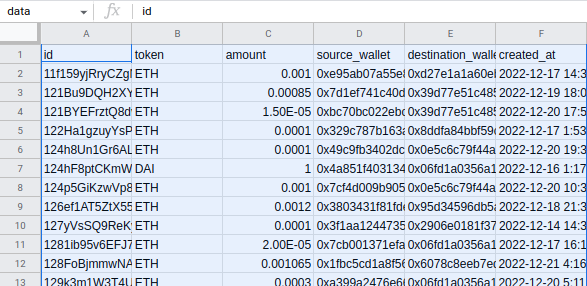

Each row shows a constribution for a given project, their id, the token sent, amount of tokens sent, project's address and the date of the contribution.

We can give the name 'data' to the current sheet so we can call from another sheet to get only unique addresses from column D (source_wallet).

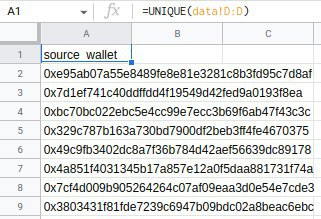

So now we have a list of addresses which we can work from.

## Getting to know if an address has an Ethereum Name Services (ENS) associated

Ethereum Name Service (ENS) is a decentralized domain name service built on the Ethereum blockchain. It allows users to associate human-readable names (e.g. "myname.eth") with Ethereum addresses, making it easier to send and receive payments, as well as access decentralized applications (dApps).

We will create a query on Flipside to determine if an address has an ENS associated with it and how many ENS names are related to the address. This will help us to confirm the legitimacy and non-sybil nature of the address.



```
-- Create a subquery with addresses we want to look at (the rest of the code is in the repository)
WITH addresses AS (
  SELECT '0xe95ab07a55e8489fe8e81e3281c8b3fd95c7d8af' as owner UNION ALL
  SELECT '0x7d1ef741c40ddffdd4f19549d42fed9a0193f8ea' UNION ALL
  SELECT '0xbc70bc022ebc5e4cc99e7ecc3b69f6ab47f43c3c')
-- Main query to join the addresses with ENS data and group by owner address 
SELECT 
  a.owner,
  COUNT(b.owner) as count, -- count of ENS names associated with owner
  (CASE 
    WHEN COUNT(b.owner) > 0 THEN 'YES' -- calculated column indicating whether address has at least one ENS name
    ELSE 'NO'
  END) as has_ens
FROM addresses a
LEFT JOIN crosschain.core.ez_ens b
ON a.owner = b.owner
GROUP BY a.owner
```



## Getting info about in an address has interacted with a defi protocol and how many times

Now we will create a query to determine if an address has interacted with a DEX. As a reminder, a DEX (decentralized exchange) is a platform in the Ethereum ecosystem that allows users to trade crypto without the need for a centralized intermediary.



```
WITH addresses AS (
  SELECT '0xe95ab07a55e8489fe8e81e3281c8b3fd95c7d8af' as owner UNION ALL
  SELECT '0x7d1ef741c40ddffdd4f19549d42fed9a0193f8ea' UNION ALL
  SELECT '0xbc70bc022ebc5e4cc99e7ecc3b69f6ab47f43c3c')
SELECT a.owner as address,
  (CASE 
    WHEN COUNT(b.tx_hash) > 0 THEN 'YES'
    ELSE 'NO'
  END) as has_defi_transactions,
  COUNT(b.tx_hash) as count_defi_transactions
  FROM addresses a
  LEFT JOIN ethereum.core.fact_transactions b
  ON b.from_address = a.owner AND b.to_address IN (SELECT address FROM ethereum.core.dim_labels WHERE label_type = 'defi')
  GROUP BY a.owner
```

The main query joins the *addresses* subquery with the transaction data from the "ethereum.core.fact_transactions" table on the "from_address" column and filters the transactions to only include those sent to addresses labeled as "defi" in the "ethereum.core.dim_labels" table.

**Other interactions for an address could include: dapp, nft, cex, layer2 and token.**

## Understanding address activity before and after December 2022

With the grants occurring in December, it's important to determine if an address had activity prior to that date, or if it was created specifically for the grant period.




```
WITH addresses AS (
  SELECT '0xe95ab07a55e8489fe8e81e3281c8b3fd95c7d8af' as owner UNION ALL
  SELECT '0x7d1ef741c40ddffdd4f19549d42fed9a0193f8ea' UNION ALL
  SELECT '0xbc70bc022ebc5e4cc99e7ecc3b69f6ab47f43c3c')
SELECT a.owner as address,
  (CASE 
    WHEN COUNT(b.tx_hash) > 0 THEN 'yes'
    ELSE 'no'
  END) as had_activity_before_december_2022,
  COUNT(b.tx_hash) as count_activity_before_december_2022
  FROM addresses a
  LEFT JOIN ethereum.core.fact_transactions b
  ON b.from_address = a.owner 
  AND b.block_timestamp::date <= '2022-12-01'
GROUP BY a.owner;
```

The main line here is ***AND b.block_timestamp::date <= '2022-12-01'***, if we want to see if there's activiy after December we just change the line to  ***AND b.block_timestamp::date >= '2023-01-01'*** 



## Combining the Results

After executing each query, the results can be downloaded in a CSV file through the Flipside Web or their API. It's now time to bring everything together using Pandas and Python, as follows:

In [2]:
import pandas as pd

# Read files
# ENS info
df_01_a = pd.read_csv('/01_ens_names_a.csv')
df_01_b = pd.read_csv('/01_ens_names_b.csv')

# DEX interactions
df_02_a = pd.read_csv('/02_dex_interactions_a.csv')
df_02_b = pd.read_csv('/02_dex_interactions_b.csv')
df_02_c = pd.read_csv('/02_dex_interactions_c.csv')

# Activity before December
df_03_a = pd.read_csv('/03_activity_bef_dec_a.csv')
df_03_b = pd.read_csv('/03_activity_bef_dec_b.csv')
df_03_c = pd.read_csv('/03_activity_bef_dec_c.csv')

# Activity after December
df_04_a = pd.read_csv('/04_activity_af_dec_a.csv')
df_04_b = pd.read_csv('/04_activity_af_dec_b.csv')
df_04_c = pd.read_csv('/04_activity_af_dec_c.csv')

# Show head content for ENS info
print(df_01_a.head())
print(df_01_b.head())

                                        OWNER  COUNT HAS_ENS
0  0xe2894fd6ca974d7d248010ac0fa98eaa27ed790a      2     YES
1  0xafab1adfb25e919d9f6ee7196f1ad0ffa93cad12      6     YES
2  0x3548cdd5222a415fb35ac65cfa9dde7f4a210efd      0      NO
3  0x6611ca1dc4f3b83b680b6672eb2dc5a2bb08702f      0      NO
4  0x4de38fd841d3be46b32bbd730e038a73e26eadf9      0      NO
                                        OWNER  COUNT HAS_ENS
0  0xd066a9202fca2a81a6a22b41f8793b8137e6aff4      0      NO
1  0xab68e3373b28e91f4496b2d0d03fc9fdbb7e092d      0      NO
2  0x7253fec458230253b3acce6a47cba1f37fc1b8cd      0      NO
3  0x3659751b8c9acfd52656be5f97bcbf675ce48480     47     YES
4  0xac2434eff71102d940374eb99c7e9b70856b61ed      0      NO


In [3]:
# Concatenate df_01_a and df_01_b
df_01 = pd.concat([df_01_a, df_01_b])
print(df_01.head())

                                        OWNER  COUNT HAS_ENS
0  0xe2894fd6ca974d7d248010ac0fa98eaa27ed790a      2     YES
1  0xafab1adfb25e919d9f6ee7196f1ad0ffa93cad12      6     YES
2  0x3548cdd5222a415fb35ac65cfa9dde7f4a210efd      0      NO
3  0x6611ca1dc4f3b83b680b6672eb2dc5a2bb08702f      0      NO
4  0x4de38fd841d3be46b32bbd730e038a73e26eadf9      0      NO


In [4]:
# Print the amount of rows on the dataframe
print(df_01.shape[0])

15511


In [6]:
# Rename columns
df_01 = df_01.rename(columns={"OWNER": "address", "COUNT": "ens_count", "HAS_ENS": "has_ens"})

print(df_01.head())

                                      address  ens_count has_ens
0  0xe2894fd6ca974d7d248010ac0fa98eaa27ed790a          2     YES
1  0xafab1adfb25e919d9f6ee7196f1ad0ffa93cad12          6     YES
2  0x3548cdd5222a415fb35ac65cfa9dde7f4a210efd          0      NO
3  0x6611ca1dc4f3b83b680b6672eb2dc5a2bb08702f          0      NO
4  0x4de38fd841d3be46b32bbd730e038a73e26eadf9          0      NO


In [7]:
# Reorder columns to have 'ens_count' to the right of 'has_ens'
cols = list(df_01.columns.values)
cols.pop(cols.index('ens_count'))
df_01 = df_01[cols + ['ens_count']]
print(df_01.head())

                                      address has_ens  ens_count
0  0xe2894fd6ca974d7d248010ac0fa98eaa27ed790a     YES          2
1  0xafab1adfb25e919d9f6ee7196f1ad0ffa93cad12     YES          6
2  0x3548cdd5222a415fb35ac65cfa9dde7f4a210efd      NO          0
3  0x6611ca1dc4f3b83b680b6672eb2dc5a2bb08702f      NO          0
4  0x4de38fd841d3be46b32bbd730e038a73e26eadf9      NO          0


### Ordering DEX csv

In [8]:
print(df_02_a.head())

                                      ADDRESS HAS_DEFI_TRANSACTIONS  \
0  0x059eeedfe126ff4c918da928a33826def7402744                   YES   
1  0xfc7c0ef10907a1ed1aea1a34642a14f8ec2d2677                   YES   
2  0x5e2699545c7644966a8dec911f026365c6cf0e2e                   YES   
3  0x97774b62789cccba78940c024adf2a69006e376c                   YES   
4  0x0945c91d5ddc3cdfdf7fdd45ded0746d0f31296e                   YES   

   COUNT_DEFI_TRANSACTIONS  
0                       15  
1                       31  
2                       33  
3                       30  
4                       13  


In [14]:
# Concatenate DEX csv

df_02 = pd.concat([df_02_a, df_02_b, df_02_c], axis = 0)
print(df_02.head())


                                      ADDRESS HAS_DEFI_TRANSACTIONS  \
0  0x059eeedfe126ff4c918da928a33826def7402744                   YES   
1  0xfc7c0ef10907a1ed1aea1a34642a14f8ec2d2677                   YES   
2  0x5e2699545c7644966a8dec911f026365c6cf0e2e                   YES   
3  0x97774b62789cccba78940c024adf2a69006e376c                   YES   
4  0x0945c91d5ddc3cdfdf7fdd45ded0746d0f31296e                   YES   

   COUNT_DEFI_TRANSACTIONS  
0                       15  
1                       31  
2                       33  
3                       30  
4                       13  


In [15]:
# Rename columns
df_02.columns = df_02.columns.str.lower()
print(df_02.head())

                                      address has_defi_transactions  \
0  0x059eeedfe126ff4c918da928a33826def7402744                   YES   
1  0xfc7c0ef10907a1ed1aea1a34642a14f8ec2d2677                   YES   
2  0x5e2699545c7644966a8dec911f026365c6cf0e2e                   YES   
3  0x97774b62789cccba78940c024adf2a69006e376c                   YES   
4  0x0945c91d5ddc3cdfdf7fdd45ded0746d0f31296e                   YES   

   count_defi_transactions  
0                       15  
1                       31  
2                       33  
3                       30  
4                       13  


In [20]:
# Reorder data before and after December 2022

# Concatenate data before 2022
df_03 = pd.concat([df_03_a, df_03_b, df_03_c], axis = 0)
df_04 = pd.concat([df_04_a, df_04_b, df_04_c], axis = 0)

# Lower column names
df_03.columns = df_03.columns.str.lower()
df_04.columns = df_04.columns.str.lower()

# Print heads
print(df_03.head())
print(df_04.head())

                                      address  \
0  0xf538baf3e2151a3c55de1cb9f1490a8284aeb0c1   
1  0x70da565928419c5380c89017e5a8f5177fb4aef1   
2  0x3c795e4f750b15b61159e8f38dca512256a021c7   
3  0x81f6274aa375e242cc80583b1c6fa139a84c2a88   
4  0x7c88565a71a1292019466c5c130e0675786a85e9   

  had_activity_before_december_2022  count_activity_before_december_2022  
0                               yes                                   14  
1                               yes                                  458  
2                               yes                                  301  
3                               yes                                   74  
4                               yes                                  680  
                                      address  \
0  0x5c0e5d06c1f0476dbc39ef9358e76d52f19667d6   
1  0x60f61ee267eeecf90c1ba19f3599d5b514cd399f   
2  0xb36f9f412959f40ca65599bfd6ac67d5b883d1d6   
3  0x1d7e454ab11603667c211b065246062c95da81d8   
4  0x27e24

In [21]:
# It looks that columns for df_04 should say 'after' insted of 'before'
df_04 = df_04.rename(columns={"had_activity_before_december_2022": "had_activity_after_december_2022", "count_activity_before_december_2022": "count_activity_after_december_2022"})

print(df_04.head())

                                      address  \
0  0x5c0e5d06c1f0476dbc39ef9358e76d52f19667d6   
1  0x60f61ee267eeecf90c1ba19f3599d5b514cd399f   
2  0xb36f9f412959f40ca65599bfd6ac67d5b883d1d6   
3  0x1d7e454ab11603667c211b065246062c95da81d8   
4  0x27e241e6fda72eada0d91a259afa84c830020153   

  had_activity_after_december_2022  count_activity_after_december_2022  
0                              yes                                  49  
1                              yes                                  32  
2                              yes                                  33  
3                              yes                                  35  
4                              yes                                  38  


In [23]:
# Merge the dataframes on the 'address' column
df = pd.merge(df_01, df_02, on='address')
df = pd.merge(df, df_03, on='address')
df = pd.merge(df, df_04, on='address')

# Check the shape of the merged dataframe
print(df.shape)


(15525, 9)


In [24]:
df = df.drop_duplicates(subset='address', keep='first')
print(df.shape)

(15510, 9)


In [25]:
print(df.head())

                                      address has_ens  ens_count  \
0  0xe2894fd6ca974d7d248010ac0fa98eaa27ed790a     YES          2   
1  0xafab1adfb25e919d9f6ee7196f1ad0ffa93cad12     YES          6   
2  0x3548cdd5222a415fb35ac65cfa9dde7f4a210efd      NO          0   
3  0x6611ca1dc4f3b83b680b6672eb2dc5a2bb08702f      NO          0   
4  0x4de38fd841d3be46b32bbd730e038a73e26eadf9      NO          0   

  has_defi_transactions  count_defi_transactions  \
0                   YES                        7   
1                   YES                       24   
2                   YES                        2   
3                    NO                        0   
4                    NO                        0   

  had_activity_before_december_2022  count_activity_before_december_2022  \
0                               yes                                  187   
1                               yes                                  371   
2                               yes               

In [27]:
# Save the dataframe to a new csv
df.to_csv('grant_votes_extended_v_01.csv', index=False)

## What's next?

We can now use the new table with additional variables to filter out addresses that show low activity, and consider them suspicious.

In [28]:
df_filtered = df[(df['has_ens'] == 'NO') & (df['has_defi_transactions'] == 'NO') & (df['had_activity_before_december_2022'] == 'no') & (df['had_activity_after_december_2022'] == 'no')]


In [32]:
# Save data
df_filtered.to_csv('probably_sybils.csv')

In [34]:
print(df_filtered.shape)

(444, 9)
